In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os


In [3]:
#dataset
class BMIDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self,idx
                    ):
        img_path = self.annotations.iloc[idx, 5]
        image = Image.open(img_path).convert("RGB")
        bmi_label = float(self.annotations.iloc[idx, 4])

        if self.transform:
            image = self.transform(image)

        return (image, bmi_label)
    

In [4]:
resize = 224

In [5]:
transform = transforms.Compose([
    transforms.Resize((resize, resize)),  # Chọn kích thước ảnh sau khi augment
    transforms.ToTensor(),  # Chuyển ảnh sang tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Chuẩn hóa tensor
])

In [6]:
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [7]:
class BMIModel(nn.Module):
    def __init__(self):
        super(BMIModel,self).__init__()
        self.conv1 = nn.Conv2d(3,6, 3) #224x224
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d( 2,2) #111x111
        
        self.conv2 = nn.Conv2d(6 ,10 , 3) # 110 x110
        self.relu2 = nn.ReLU()
        self.batch2 = nn.BatchNorm2d(10)
        self.pool2 = nn.MaxPool2d( 2,2)# 55x55
        
        self.l_conv1 = int((224- 3) + 1)
        self.l_maxpool1= int((self.l_conv1 - 2)/2 + 1)

        self.l_conv2 = int((self.l_maxpool1- 3) + 1)
        self.l_maxpool2= int((self.l_conv2 - 2)/2 + 1)        
        self.linear = nn.Linear(self.l_maxpool2*self.l_maxpool2*10,1)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.batch1(x)
        x = self.pool1(x)
        
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batch2(x)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        
        return x

In [8]:
dataset = BMIDataset(csv_file ='/home/quanhhh/Documents/pre_bmi/pr_databmi.csv',
                     root_dir = '/home/quanhhh/Documents/vip/vip/data/data/',
                     transform = transform )

In [9]:
annotations = pd.read_csv('/home/quanhhh/Documents/pre_bmi/pr_databmi.csv')
img_path = annotations.iloc[ : , 5]
img_path

0       /home/quanhhh/Documents/vip/vip/data/data/f_00...
1       /home/quanhhh/Documents/vip/vip/data/data/f_00...
2       /home/quanhhh/Documents/vip/vip/data/data/f_00...
3       /home/quanhhh/Documents/vip/vip/data/data/f_00...
4       /home/quanhhh/Documents/vip/vip/data/data/f_00...
                              ...                        
1021    /home/quanhhh/Documents/vip/vip/data/data/m_50...
1022    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1023    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1024    /home/quanhhh/Documents/vip/vip/data/data/m_51...
1025    /home/quanhhh/Documents/vip/vip/data/data/m_51...
Name: path, Length: 1026, dtype: object

In [10]:
#set up data loader and transformations
total_samples = len(dataset)
total_samples
from torch.utils.data import random_split
total_samples = len(dataset)
train_size = int(0.7 * total_samples)  # Adjust the split ratio as needed
test_size = total_samples - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])

In [11]:
batch_size = 226


In [12]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size= 308, shuffle=True)



In [13]:
model = BMIModel()


In [14]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [15]:
criterion = RMSELoss()  # Root Mean Squared Error Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [16]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [17]:


#create variable to tracks things
num_epochs = 25

losses = []

n_total_steps = len(train_loader)
#For Loop of epochs
for epoch in range(num_epochs):
   
    
    #train
   
    for i, (image, bmi_labels) in enumerate(train_loader):
        
    
        y_pred = model(image)
        loss = criterion(y_pred, bmi_labels.view(-1, 1).float())/len(train_loader)
        losses.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if(i+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
print("finish training")

Epoch [1/25], Step [1/4], Loss: 5.9327
Epoch [1/25], Step [2/4], Loss: 3.3256
Epoch [1/25], Step [3/4], Loss: 2.3941
Epoch [1/25], Step [4/4], Loss: 3.2449
Epoch [2/25], Step [1/4], Loss: 2.7719
Epoch [2/25], Step [2/4], Loss: 2.2090
Epoch [2/25], Step [3/4], Loss: 1.9342
Epoch [2/25], Step [4/4], Loss: 2.5246
Epoch [3/25], Step [1/4], Loss: 2.0167
Epoch [3/25], Step [2/4], Loss: 2.0365
Epoch [3/25], Step [3/4], Loss: 1.9393
Epoch [3/25], Step [4/4], Loss: 1.9575
Epoch [4/25], Step [1/4], Loss: 1.7090
Epoch [4/25], Step [2/4], Loss: 1.6666
Epoch [4/25], Step [3/4], Loss: 1.6481
Epoch [4/25], Step [4/4], Loss: 1.8435
Epoch [5/25], Step [1/4], Loss: 1.3089
Epoch [5/25], Step [2/4], Loss: 1.7287
Epoch [5/25], Step [3/4], Loss: 1.4710
Epoch [5/25], Step [4/4], Loss: 1.2136
Epoch [6/25], Step [1/4], Loss: 1.1676
Epoch [6/25], Step [2/4], Loss: 1.2922
Epoch [6/25], Step [3/4], Loss: 1.4593
Epoch [6/25], Step [4/4], Loss: 1.1592
Epoch [7/25], Step [1/4], Loss: 1.1609
Epoch [7/25], Step [2/4],

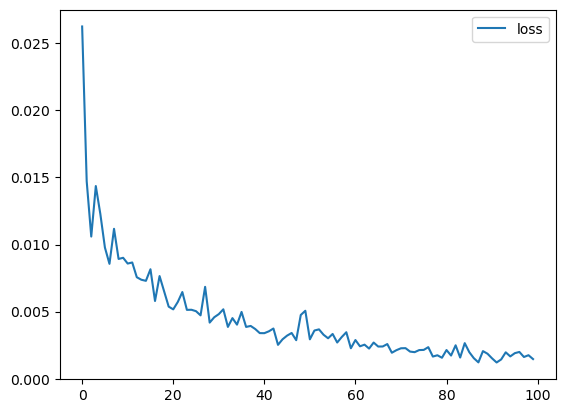

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
losses = [tl.item() for tl in losses]
plt.plot( [t /226 for t in losses ], label = "loss")

plt.legend()
          

In [19]:
test_loss = 0.0
test_score = 0.0
test_loss_list = []
pred_list = []
truth_list = []
label_list = []
score_list = []


In [20]:
from sklearn.metrics import mean_absolute_error
losses_ = []
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, bmi_labels in test_loader:
        # Assuming your model takes images as input
        bmi_out = model(images)
        loss_ = criterion(bmi_out, bmi_labels.view(-1, 1).float())/len(train_loader)
        losses_.append(loss)
        bmi_out = pd.DataFrame(bmi_out)
        print(bmi_out)
        bmi_labels = pd.DataFrame(bmi_labels)
        print(bmi_labels)
        
# Compute accuracy
   
    score = mean_absolute_error(bmi_labels, bmi_out)
    print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))

             0
0    20.670174
1    27.395277
2    20.756493
3    24.100578
4    21.263443
..         ...
303  17.431335
304  17.639170
305  22.401367
306  26.569967
307  20.260227

[308 rows x 1 columns]
             0
0    18.710949
1    22.724403
2    19.487383
3    19.157088
4    26.783540
..         ...
303  23.040020
304  23.388687
305  17.674536
306  27.770313
307  22.351743

[308 rows x 1 columns]
The Mean Absolute Error of our Model is 3.44


In [31]:
torch.save(model, 'model.pth')

In [32]:
model = torch.load('model.pth')

for para in model.parameters():
    print(para)

Parameter containing:
tensor([[[[ 0.1603, -0.1444,  0.1477],
          [-0.1502,  0.1898,  0.1627],
          [ 0.0838, -0.0696,  0.0054]],

         [[ 0.0704,  0.0594,  0.0804],
          [-0.0751,  0.1958,  0.1074],
          [-0.0803, -0.0701,  0.1866]],

         [[-0.0613,  0.0322, -0.0695],
          [-0.1170, -0.0657, -0.1222],
          [ 0.0787, -0.0098,  0.1279]]],


        [[[-0.0278,  0.0554, -0.1006],
          [ 0.1455,  0.1801, -0.0102],
          [ 0.1171,  0.1501,  0.1304]],

         [[-0.1136, -0.1033, -0.0143],
          [-0.0725, -0.0807,  0.1299],
          [ 0.0469, -0.0513, -0.1628]],

         [[-0.1721,  0.0343,  0.0003],
          [-0.1574, -0.1695, -0.0748],
          [-0.1801,  0.1595, -0.1742]]],


        [[[-0.1459,  0.1824, -0.0715],
          [-0.1453, -0.1330, -0.0930],
          [ 0.1563,  0.1462,  0.0692]],

         [[ 0.0180, -0.0382, -0.1240],
          [-0.1196, -0.1527, -0.0842],
          [-0.0083, -0.0105,  0.0149]],

         [[ 0.0748, -0

In [23]:
def train():
    # train_epoch
    # test_epoch
    # luu model/ tra ve model
    # self.best_model = copy.deepcopy(self.model)
    pass




In [24]:
with torch.no_grad():
    image = Image.open('a.jpg').convert("RGB")
   
    image = transform(image)
    image = image.unsqueeze_(0)
    #y =image.size()
    y = model(image)

    print(y)

tensor([[26.5328]])
